In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from  sklearn.preprocessing import LabelEncoder
from  sklearn.preprocessing import OneHotEncoder
import scipy 
from scipy.sparse import coo_matrix, hstack

from __future__ import division
from scipy.special import erfinv


from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score


In [3]:
df_train = pd.read_csv("../data/new_train_full.csv").fillna(0.0)
df_test = pd.read_csv("../data/new_test_full.csv").fillna(0.0)

In [4]:
df_train = df_train.drop( ["TARGET"] , axis = 1 ) 
test_ids = df_test["SK_ID_CURR"].values
#df_test = df_test.drop( ["SK_ID_CURR"] , axis = 1 ) 

In [5]:
df_labels = pd.read_csv("../data/labels_train.csv" , header = None )
labels_train = df_labels[1]
labels_train.shape

(307511,)

In [10]:
positive_data_indx = df_labels[ df_labels[1] == 1 ]
positive_data = df_train.iloc[ positive_data_indx.index ]
#print( positive_data.shape )
negative_data_indx = df_labels[  df_labels[1] == 0 ]
negative_data = df_train.iloc[  negative_data_indx.index ]
#print( negative_data.shape )

In [11]:
positive_ratio = float(len(positive_data)) / len(df_train)


In [12]:
cols = [x for x  in list(df_train.columns) if "SK" in x ]
df_train = df_train.drop( cols , axis = 1 )
df_test = df_test.drop( cols , axis = 1 )
print( df_train.shape )
print(df_test.shape)

(307511, 714)
(48744, 714)


In [13]:
labels_train = df_labels[1].values

In [14]:
features_train_num = df_train.select_dtypes(include=[np.number])
features_test_num = df_test.select_dtypes(include=[np.number])
features_train_cat =df_train.select_dtypes(include=[object])
features_test_cat = df_test.select_dtypes(include=[object])

In [15]:
cats_not_doc = [ x for x in features_train_num.columns if not x.startswith("FLAG_DOCUMENT")]
features_train_num = features_train_num[ cats_not_doc ]
features_test_num = features_test_num[ cats_not_doc ]

In [16]:
not_flags = [ x for x in features_train_num.columns if  not x.startswith("FLAG")]
flags = [ x for x in features_train_num.columns if x.startswith("FLAG")]

new_cats_train = features_train_num[ flags ]
new_cats_test = features_test_num[ flags ]

features_train_num = features_train_num.drop( flags , axis = 1 )
features_test_num = features_test_num.drop( flags , axis = 1 )

features_train_cat = pd.concat( [features_train_cat  , new_cats_train ]  , axis = 1 )
features_test_cat = pd.concat( [features_test_cat , new_cats_test] , axis = 1  )


features_train_num.head()


,LIVINGAPARTMENTS_MODE,REGION_POPULATION_RELATIVE,DAYS_ID_PUBLISH,DAYS_REGISTRATION,COMMONAREA_AVG,OBS_60_CNT_SOCIAL_CIRCLE,LIVINGAREA_MODE,ENTRANCES_AVG,LIVINGAREA_MEDI,ENTRANCES_MEDI,...,MAX(prev.MAX(card.AMT_DRAWINGS_ATM_CURRENT)),STD(prev.MAX(card.AMT_DRAWINGS_OTHER_CURRENT)),MAX(prev.AMT_GOODS_PRICE),LAST(bureau.CNT_CREDIT_PROLONG),MAX(prev.MEAN(card.AMT_BALANCE)),MAX(prev.MEAN(pos.CNT_INSTALMENT)),MAX(prev.STD(card.AMT_INST_MIN_REGULARITY)),STD(prev.MAX(card.AMT_PAYMENT_TOTAL_CURRENT)),MAX(prev.MAX(card.AMT_RECEIVABLE_PRINCIPAL)),LAST(prev.LAST(instal.NUM_INSTALMENT_VERSION))
0,0.022,0.018801,-2120,-3648.0,0.0143,2.0,0.0198,0.0690,0.0193,0.0690,...,0.0,0.0,179055.0,0.0,0.0,24.000000,0.0,0.0,0.0,1.0
1,0.079,0.003541,-291,-1186.0,0.0605,1.0,0.0554,0.0345,0.0558,0.0345,...,0.0,0.0,900000.0,0.0,0.0,12.000000,0.0,0.0,0.0,1.0
2,0.000,0.010032,-2531,-4260.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,24282.0,0.0,0.0,3.750000,0.0,0.0,0.0,2.0
3,0.000,0.008019,-2437,-9833.0,0.0000,2.0,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,688500.0,0.0,0.0,16.666667,0.0,0.0,0.0,0.0
4,0.000,0.028663,-3458,-4311.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,...,0.0,0.0,247500.0,0.0,0.0,24.000000,0.0,0.0,0.0,0.0


In [17]:
for col in features_train_cat.columns:
    
    df_ = pd.concat( [features_train_cat[col] , features_test_cat[col] ]   )
    
    enc = LabelEncoder()
    enc.fit( df_.values ) 
    features_train_cat[col] = enc.transform( features_train_cat[col] )
    features_test_cat[col] = enc.transform( features_test_cat[col] )
    

In [18]:
features_test_cat.head()

,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FLAG_OWN_REALTY,NAME_TYPE_SUITE,FLAG_OWN_CAR,NAME_CONTRACT_TYPE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS,WALLSMATERIAL_MODE,OCCUPATION_TYPE,...,LAST(prev.NAME_PRODUCT_TYPE),LAST(prev.NAME_PORTFOLIO),LAST(prev.NAME_GOODS_CATEGORY),LAST(prev.NAME_CONTRACT_TYPE),FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_EMAIL,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMP_PHONE
0,5,28,1,7,0,0,1,1,6,0,...,1,4,19,2,1,0,1,1,0,1
1,0,42,1,7,0,0,1,1,0,10,...,1,4,19,2,1,0,0,1,0,1
2,1,54,1,0,1,0,1,1,0,5,...,1,4,19,2,1,0,0,1,0,1
3,6,5,1,7,0,0,1,1,5,15,...,1,4,5,2,1,0,0,1,1,1
4,0,5,0,7,1,0,1,1,0,0,...,1,4,5,2,1,1,0,1,0,1


In [19]:
features_test_cat.shape

(48744, 44)

In [20]:
#features_train_cat = features_train_cat[cats_not_doc]
#features_test_cat = features_test_cat[cats_not_doc]

In [21]:
df_ = pd.concat( [features_train_cat , features_test_cat ] , axis = 0 )
enc = OneHotEncoder()
enc.fit( df_ )
onehot_train = enc.transform( features_train_cat )
onehot_test = enc.transform( features_test_cat )

In [22]:
features_test_cat.shape

(48744, 44)

In [23]:
onehot_test.shape

(48744, 366)

In [24]:
features_train_num.shape

(307511, 650)

In [25]:
def rank_gauss(x):
    # x is numpy vector
    N = x.shape[0]
    temp = x.argsort()
    rank_x = temp.argsort() / N
    rank_x -= rank_x.mean()
    rank_x *= 2 # rank_x.max(), rank_x.min() should be in (-1, 1)
    efi_x = erfinv(rank_x) # np.sqrt(2)*erfinv(rank_x)
    efi_x -= efi_x.mean()
    return efi_x

In [26]:
#features_train_num2 =  features_train_num.apply(  rank_gauss )

In [27]:
#features_test_num2 = features_test_num.apply( rank_gauss )

In [28]:
s = features_train_num.shape[0]
for col in features_train_num.columns:
    #plt.hist( features_train_num2[col].values )
    print( col )
    zeros = np.count_nonzero( features_train_num[col].values )
    print( "Ratios nonzeros/total" , zeros/s )
    #plt.title( fn )
    #plt.show()

LIVINGAPARTMENTS_MODE
('Ratios nonzeros/total', 0.31476272393507876)
REGION_POPULATION_RELATIVE
('Ratios nonzeros/total', 1.0)
DAYS_ID_PUBLISH
('Ratios nonzeros/total', 0.9999479693409341)
DAYS_REGISTRATION
('Ratios nonzeros/total', 0.9997398467046708)
COMMONAREA_AVG
('Ratios nonzeros/total', 0.27382435099882607)
OBS_60_CNT_SOCIAL_CIRCLE
('Ratios nonzeros/total', 0.4611997619597348)
LIVINGAREA_MODE
('Ratios nonzeros/total', 0.4966228850350069)
ENTRANCES_AVG
('Ratios nonzeros/total', 0.4954619509546)
LIVINGAREA_MEDI
('Ratios nonzeros/total', 0.49709441288279116)
ENTRANCES_MEDI
('Ratios nonzeros/total', 0.4954424394574503)
APARTMENTS_AVG
('Ratios nonzeros/total', 0.490060518160326)
TOTALAREA_MODE
('Ratios nonzeros/total', 0.5154222125387384)
REG_CITY_NOT_WORK_CITY
('Ratios nonzeros/total', 0.23045354475124466)
ELEVATORS_AVG
('Ratios nonzeros/total', 0.18829245132694442)
EXT_SOURCE_2
('Ratios nonzeros/total', 0.9978537353135335)
AMT_CREDIT
('Ratios nonzeros/total', 1.0)
DEF_30_CNT_SOCIAL_

('Ratios nonzeros/total', 0.16700215602043503)
MAX(prev.LAST(card.AMT_DRAWINGS_ATM_CURRENT))
('Ratios nonzeros/total', 0.04010913430739063)
LAST(prev.MAX(instal.NUM_INSTALMENT_NUMBER))
('Ratios nonzeros/total', 0.6563049777081145)
MAX(prev.MAX(card.AMT_PAYMENT_CURRENT))
('Ratios nonzeros/total', 0.17145728120294884)
MEAN(prev.AMT_CREDIT)
('Ratios nonzeros/total', 0.9457547860076551)
MAX(bureau.AMT_CREDIT_MAX_OVERDUE)
('Ratios nonzeros/total', 0.22906497653742466)
MAX(prev.MAX(card.AMT_PAYMENT_TOTAL_CURRENT))
('Ratios nonzeros/total', 0.1714280139572243)
MAX(bureau.AMT_CREDIT_SUM_LIMIT)
('Ratios nonzeros/total', 0.15867074673751508)
MEAN(prev.LAST(card.AMT_DRAWINGS_ATM_CURRENT))
('Ratios nonzeros/total', 0.04010913430739063)
LAST(prev.DAYS_LAST_DUE_1ST_VERSION)
('Ratios nonzeros/total', 0.6770847221725401)
MEAN(bureau.STD(bureau_bal.MONTHS_BALANCE))
('Ratios nonzeros/total', 0.2991762896286637)
STD(prev.MEAN(card.CNT_DRAWINGS_POS_CURRENT))
('Ratios nonzeros/total', 0.10346296555245178)


('Ratios nonzeros/total', 0.13818042281414322)
STD(prev.LAST(card.AMT_BALANCE))
('Ratios nonzeros/total', 0.11241549082797038)
MEAN(prev.MEAN(card.AMT_RECEIVABLE_PRINCIPAL))
('Ratios nonzeros/total', 0.1661566578106149)
LAST(prev.MAX(card.AMT_PAYMENT_CURRENT))
('Ratios nonzeros/total', 0.03634341535749941)
MEAN(prev.MAX(card.MONTHS_BALANCE))
('Ratios nonzeros/total', 0.2534348364773943)
MEAN(bureau.AMT_CREDIT_SUM_OVERDUE)
('Ratios nonzeros/total', 0.010841888582847443)
MAX(prev.MAX(pos.MONTHS_BALANCE))
('Ratios nonzeros/total', 0.32132509080975963)
MEAN(prev.STD(card.CNT_INSTALMENT_MATURE_CUM))
('Ratios nonzeros/total', 0.16624771146398015)
MAX(prev.LAST(instal.DAYS_ENTRY_PAYMENT))
('Ratios nonzeros/total', 0.35785386539018116)
LAST(prev.AMT_APPLICATION)
('Ratios nonzeros/total', 0.7843816969149071)
STD(prev.LAST(card.AMT_CREDIT_LIMIT_ACTUAL))
('Ratios nonzeros/total', 0.22688944460523364)
STD(prev.MEAN(card.AMT_PAYMENT_TOTAL_CURRENT))
('Ratios nonzeros/total', 0.16773708907974025)
MAX

('Ratios nonzeros/total', 0.16684281212704585)
MEAN(prev.MEAN(instal.NUM_INSTALMENT_VERSION))
('Ratios nonzeros/total', 0.9329097170507722)
MEAN(prev.LAST(instal.NUM_INSTALMENT_NUMBER))
('Ratios nonzeros/total', 0.941124057350794)
MAX(bureau.DAYS_ENDDATE_FACT)
('Ratios nonzeros/total', 0.1498645576906192)
LAST(prev.MAX(card.CNT_INSTALMENT_MATURE_CUM))
('Ratios nonzeros/total', 0.035406863494314024)
MEAN(prev.NFLAG_LAST_APPL_IN_DAY)
('Ratios nonzeros/total', 0.9463563905031039)
MAX(prev.MAX(instal.AMT_PAYMENT))
('Ratios nonzeros/total', 0.941098042021261)
LAST(prev.MEAN(card.AMT_DRAWINGS_POS_CURRENT))
('Ratios nonzeros/total', 0.02171304441141943)
LAST(prev.LAST(instal.AMT_INSTALMENT))
('Ratios nonzeros/total', 0.6562789623785816)
MAX(prev.STD(card.CNT_DRAWINGS_CURRENT))
('Ratios nonzeros/total', 0.17001668233006298)
STD(prev.STD(card.AMT_PAYMENT_TOTAL_CURRENT))
('Ratios nonzeros/total', 0.16739238596342895)
MAX(prev.MAX(pos.CNT_INSTALMENT))
('Ratios nonzeros/total', 0.933088572441311)


('Ratios nonzeros/total', 0.16606235224105803)
LAST(prev.LAST(instal.NUM_INSTALMENT_VERSION))
('Ratios nonzeros/total', 0.6196949052229026)


In [29]:
features_train_num_sp = scipy.sparse.csr_matrix(features_train_num.values)
features_test_num_sp = scipy.sparse.csr_matrix(features_test_num.values)


In [30]:
features_test_cat.head()

,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FLAG_OWN_REALTY,NAME_TYPE_SUITE,FLAG_OWN_CAR,NAME_CONTRACT_TYPE,NAME_HOUSING_TYPE,NAME_FAMILY_STATUS,WALLSMATERIAL_MODE,OCCUPATION_TYPE,...,LAST(prev.NAME_PRODUCT_TYPE),LAST(prev.NAME_PORTFOLIO),LAST(prev.NAME_GOODS_CATEGORY),LAST(prev.NAME_CONTRACT_TYPE),FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_EMAIL,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMP_PHONE
0,5,28,1,7,0,0,1,1,6,0,...,1,4,19,2,1,0,1,1,0,1
1,0,42,1,7,0,0,1,1,0,10,...,1,4,19,2,1,0,0,1,0,1
2,1,54,1,0,1,0,1,1,0,5,...,1,4,19,2,1,0,0,1,0,1
3,6,5,1,7,0,0,1,1,5,15,...,1,4,5,2,1,0,0,1,1,1
4,0,5,0,7,1,0,1,1,0,0,...,1,4,5,2,1,1,0,1,0,1


In [31]:
#features_train_t = hstack( [ onehot_train , features_train_num_sp ]   )
#features_test_t = hstack( [ onehot_test , features_test_num_sp ]   )

features_train_t = pd.concat( [ features_train_cat , features_train_num ] , axis = 1 )
features_test_t = pd.concat( [ features_test_cat , features_test_num ] , axis = 1 )

In [32]:
#pd.DataFrame( features_train_t.todense() ).to_csv("../data/sparse/train2.csv" , index = False )
#features_train_t.to_csv("../data/sparse/train_new2.csv" , index = False) 

In [33]:
#pd.DataFrame( features_test_t.todense() ).to_csv("../data/sparse/test2.csv" , index = False )
#features_test_t.to_csv("../data/sparse/test_new2.csv" , index = False) 

In [35]:
#scipy.sparse.save_npz("../data/features_train_onehot.bin", features_train_t , compressed=True)
#scipy.sparse.save_npz("../data/features_test_onehot.bin", features_test_t , compressed=True)

In [ ]:
x_train , x_val , y_train , y_val = train_test_split( features_train_t , labels_train , test_size = 0.3 , random_state=42)

In [ ]:
x_train.shape

In [38]:
ncat = features_train_cat.shape[1]
ncat

44

In [39]:
#y_val.sum()/y_val.shape[0]

In [40]:
#lgb_train = lgb.Dataset( x_train , y_train)
#lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)
learning_rate = 0.1
num_leaves = 15
min_data_in_leaf = 2000
feature_fraction = 0.8
num_boost_round = 10000
params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "metric":["auc" ,"binary_logloss"] , 
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 0,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 10,
          "min_child_weight": 150,
          "min_split_gain": 0,
          "subsample": 0.9 , 
}


In [42]:
NFOLDS = 3
kfold = KFold(n_splits=NFOLDS, shuffle=True, random_state=666)
#X = features_train_t.values
X_test = features_test_t.values

positive_data = features_train_t.iloc[ positive_data_indx.index ]
negative_data = features_train_t.iloc[ negative_data_indx.index ]

X_full = features_train_t.copy()
labels_full = df_labels[1].values
print( X_full.shape )
print( labels_full.shape) 

final_cv_train = np.zeros(len(labels_train))

final_cv_pred = np.zeros(len( test_ids ))
x_score = []


for s in range(5):
    cv_train = np.zeros(len(labels_train))
    cv_pred = np.zeros(len(test_ids))

    params['seed'] = s
    
    negative_data_sample = negative_data.sample( frac= positive_ratio / (1 - positive_ratio), random_state=s)
    labels_neg = [  0 for x in range( negative_data_sample.shape[0] ) ]
    labels_pos = [ 1 for x in range( positive_data.shape[0] )   ]
    labels_train = labels_pos + labels_neg
    
    X_train = pd.concat( [positive_data , negative_data_sample] , axis = 0  )
    X_train["y"] = labels_train
    X_train = X_train.sample( frac = 1 )
    labels_train = X_train["y"].values
    X = X_train.drop( ["y"] , axis = 1 ).values
    print("Shape Sampled data ")
    print( X.shape )
    kf = kfold.split( X ,   labels_train )
    best_trees = []
    fold_scores = []
    for i, (train_fold, validate) in enumerate(kf):
        
    
        X_train, X_validate, label_train, label_validate = X[train_fold, :], X[validate, :], labels_train[train_fold], labels_train[validate]
        dtrain = lgb.Dataset(X_train, label_train ,  categorical_feature= range(ncat))
        
        dvalid = lgb.Dataset(   X_validate , label_validate , reference=dtrain , categorical_feature=range(ncat))
        bst = lgb.train(params, dtrain, num_boost_round, valid_sets=dvalid , verbose_eval=100,early_stopping_rounds=100)
        best_trees.append(bst.best_iteration)
        cv_pred += bst.predict(X_test, num_iteration=bst.best_iteration)
        cv_train[validate] += bst.predict(X_validate)
            
            
        score = roc_auc_score( label_validate, cv_train[validate] )
        print( score )
        fold_scores.append(score)

    cv_pred /= NFOLDS
    final_cv_train += cv_train
    final_cv_pred += cv_pred

    print("cv score:")
    print( roc_auc_score(labels_train, cv_train))
    print( "current score:", roc_auc_score( labels_train , final_cv_train / (s + 1.)), s+1)
    print(fold_scores)
    print(best_trees, np.mean(best_trees))

    x_score.append(roc_auc_score( labels_train , cv_train))

(307511, 694)
(307511,)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.573892	valid_0's auc: 0.770974
[200]	valid_0's binary_logloss: 0.571497	valid_0's auc: 0.773444
Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 0.571383	valid_0's auc: 0.773475
0.7734748432614424
Training until validation scores don't improve for 100 rounds.


KeyboardInterrupt: 

In [84]:
len( x_score )

16

In [29]:
print( x_score )

[0.7802048058632256, 0.7797928456398185, 0.7796398301122296, 0.7804649766052669, 0.7794792447039424, 0.7808155899158667, 0.7798833415023436, 0.7799209572103669, 0.7800713683159632, 0.7802800576563769, 0.7802783028029086, 0.7795886784492074, 0.7797225446281573, 0.7799021716571728, 0.780475033490235, 0.780280711291201]


In [30]:
print( np.array(x_score).mean() )

0.7800500287402676


In [88]:
preds = final_cv_pred / 16.0

In [89]:
preds

array([0.60502483, 0.35149295, 0.61977448, ..., 0.84532853, 0.63969579,
       0.31554582])

In [34]:
#df_preds_nn = pd.read_csv("../data/preds_nn_new.csv" )

In [20]:
df_preds_nn.head()

,Unnamed: 0,index,preds
0,0,0,0.000089
1,1,1,0.077871
2,2,2,0.000748
3,3,3,0.006218
4,4,4,0.022741


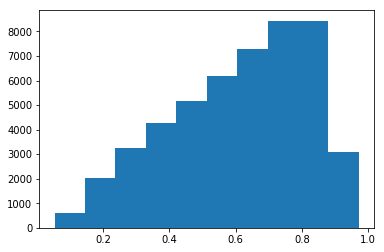

In [86]:
plt.hist( final_cv_pred/16.0 )
plt.show()

In [35]:
pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': preds }).to_csv('../data/pred_gbm_new.csv', index=False)

In [139]:

best_trees

[247, 341, 449, 402, 420]

In [38]:
x_train , x_val , y_train , y_val = train_test_split( features_train_t , labels_train , test_size = 0.3 , random_state=42)

In [39]:
dtrain = lgb.Dataset( x_train, y_train)
dvalid = lgb.Dataset( x_val , y_val, reference=dtrain)
bst = lgb.train(params, dtrain, num_boost_round, valid_sets=dvalid , verbose_eval=100,early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.241855	valid_0's auc: 0.771357
[200]	valid_0's binary_logloss: 0.239994	valid_0's auc: 0.776297
[300]	valid_0's binary_logloss: 0.239935	valid_0's auc: 0.776268
Early stopping, best iteration is:
[244]	valid_0's binary_logloss: 0.239797	valid_0's auc: 0.776757


Plot feature importances...


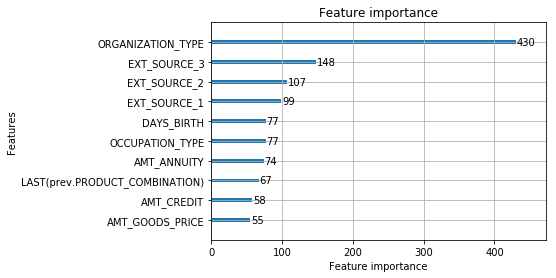

In [40]:
print('Plot feature importances...')
ax = lgb.plot_importance( bst , max_num_features=10)
plt.show()